In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly.express as px

output_df = pd.read_csv("../csv-files/CLs_predictions/4l_128n_75e_0.005lr_MAE_with_all_data.csv")

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Number of models in bins of LSP mass (scaled to match pMSSM paper)'}, xlabel='m_chi_10 [GeV]', ylabel='Number of models'>)

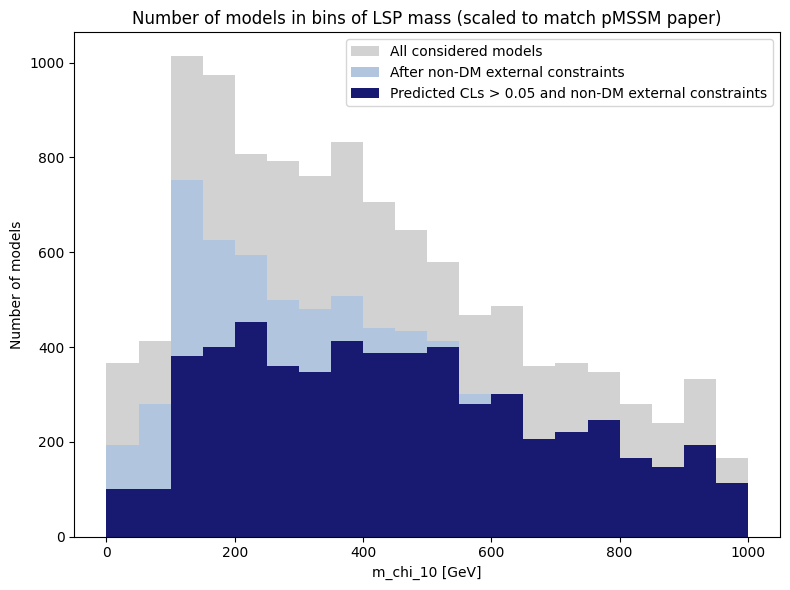

In [5]:
# Recreating figure 4 from pMSSM paper
def recreate_figure_4b_from_pMSSM_paper(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    valid_CLs_models = df["Predicted_Final__CLs"] > 0.05
    valid_external_constraints_models = (df["Constraints__Flavour"] == 1) & (df["Constraints__EW"] == 1)
    
    # For figure 4a, you need to split dataset into bino-, wino-, and higgsino-like LSP. Doesn't work well because numbers are too small to be smooth
    bino_like_LSP = df["LSP_type"] == 1
    wino_like_LSP = df["LSP_type"] == 2
    higgsino_like_LSP = df["LSP_type"] == 3
    
    # Create bins
    bins = np.linspace(0, 1000, num_bins + 1)
    
    # Compute number of models for each bin
    number_of_models_by_bin = []
    valid_external_constraints_by_bin = []
    allowed_models_by_bin = []
    
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin
        bin_mask = (m_chi_10 >= bins[i]) & (m_chi_10 < bins[i+1])
        valid_external_constraints_bin_mask = bin_mask & valid_external_constraints_models
        valid_CLs_and_external_constraints_bin_mask = bin_mask & valid_CLs_models & valid_external_constraints_models
        
        # Calculate number of models for this bin
        number_of_models = bin_mask.sum()
        num_valid_external_constraints_models = valid_external_constraints_bin_mask.sum()
        num_valid_CLs_and_external_constraints_models = valid_CLs_and_external_constraints_bin_mask.sum()
        
        # We only have 15% of the original dataset as we trained on the first 85%. Rescale to original to make a fair comparison
        scaled_number_of_models = number_of_models / 0.15
        scaled_num_external_constraints = num_valid_external_constraints_models / 0.15
        scaled_num_of_valid_models = num_valid_CLs_and_external_constraints_models / 0.15
        
        # Store results in array
        number_of_models_by_bin.append(scaled_number_of_models)
        valid_external_constraints_by_bin.append(scaled_num_external_constraints)
        allowed_models_by_bin.append(scaled_num_of_valid_models)
        bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(8,6))
    plt.bar(bin_centers, number_of_models_by_bin, width=(bins[1]-bins[0]), color="#d2d2d3")
    plt.bar(bin_centers, valid_external_constraints_by_bin, width=(bins[1]-bins[0]), color="#b1c5de")
    plt.bar(bin_centers, allowed_models_by_bin, width=(bins[1]-bins[0]), color="#181971")
    
    plt.title('Number of models in bins of LSP mass (scaled to match pMSSM paper)')
    plt.xlabel('m_chi_10 [GeV]')
    plt.ylabel('Number of models')
    
    plt.tight_layout()
    plt.legend(["All considered models", "After non-DM external constraints", "Predicted CLs > 0.05 and non-DM external constraints"])
    #plt.savefig("../plots/CLs_predictor_performance/recreate_figure_4b.pdf")
    
    return plt.gcf(), plt.gca()

recreate_figure_4b_from_pMSSM_paper(output_df, 20)

In [71]:
def heatmap(df, num_bins):
    
    m_chi_10 = df["m_chi_10"]
    m_chi_20 = df["m_chi_20"]
    
    M1_bins = np.linspace(0, max(m_chi_10), num_bins+1)
    M2_bins = np.linspace(0, max(m_chi_20), num_bins+1)
    
    mean_true_CLs = []
    mean_pred_CLs = []
    
    for i in range(num_bins):
        
        mean_j_true_CLs = []
        mean_j_pred_CLs = []
        
        for j in range(num_bins):
            bin_mask = (m_chi_10 >= M1_bins[j]) & (m_chi_10 < M1_bins[j+1]) & (m_chi_20 >= M2_bins[i]) & (m_chi_20 < M2_bins[i+1])
            
            mean_bin_true_CLs = df[bin_mask]["Final__CLs"].mean()
            mean_bin_pred_CLs = df[bin_mask]["Predicted_Final__CLs"].mean()
            
            mean_j_true_CLs.append(mean_bin_true_CLs)
            mean_j_pred_CLs.append(mean_bin_pred_CLs)
            
        mean_true_CLs.append(mean_j_true_CLs)
        mean_pred_CLs.append(mean_j_pred_CLs)
    
    mean_true_CLs = mean_true_CLs[::-1]
    mean_pred_CLs = mean_pred_CLs[::-1]
    
    mean_true_CLs = np.array(mean_true_CLs)
    mean_pred_CLs = np.array(mean_pred_CLs)
    
    fig_x=np.linspace(0, max(m_chi_10), num_bins)
    fig_y=np.linspace(0, max(m_chi_20), num_bins)
    
    fig_true = px.imshow(mean_true_CLs, 
                     labels=dict(x="m_chi_10", y="m_chi_20", color="True CLs"), 
                     x=fig_x, y=fig_y, origin="lower", width=800, height=600)
    
    fig_true.update_layout(
        margin=dict(l=0, r=50, t=50, b=50)
    )
    
    fig_pred = px.imshow(mean_pred_CLs,
                     labels=dict(x="m_chi_10", y="m_chi_20", color="Predicted CLs"), 
                     x=fig_x, y=fig_y, origin="lower", width=800, height=600)
    
    fig_diff = px.imshow(mean_true_CLs - mean_pred_CLs,
                     labels=dict(x="m_chi_10", y="m_chi_20", color="True - predicted CLs"), 
                     x=fig_x, y=fig_y, origin="lower", width=800, height=600)
    
    fig_true.show()
    fig_pred.show()
    fig_diff.show()
    
heatmap(output_df, 30)